# Sensorless Drive Diagnosis

> In this example, the main focus is the classification of individual states of a motor.

In [ ]:
# |hide
from nbdev.showdoc import *

In [ ]:
# | hide
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import copy

# from mlflow import log_metric, log_param, log_artifacts
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from matplotlib import pyplot as plt
import seaborn as sns

from mlmvn.layers import FirstLayer, HiddenLayer, OutputLayer, cmplx_phase_activation
from mlmvn.loss import ComplexMSELoss
from mlmvn.optim import MySGD, ECL

import wandb

In [ ]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: antonpf. Use `wandb login --relogin` to force relogin


True

In [ ]:
# | hide
# --- helper functions ---
def reverse_one_hot(x, neuronCats):
    a = np.zeros(len(x))
    x = torch.detach(x)
    for i in range(len(x)):
        a[i] = torch.max(x[i]) - 1 + np.argmax(x[i]) * neuronCats
    return a


def accuracy(out, yb):
    out = out.type(torch.double)
    yb = yb.type(torch.double)
    x = 0
    for i in range(len(out)):
        x += torch.equal(out[i], yb[i])
    return x / len(out)


def prepare_data(x_train, x_valid, y_train, y_valid, neuronCats):
    # one-hot encoding
    numSamples, numFeatures = x_valid.shape
    y_valid_int = y_valid
    y2 = y_valid + 1  # auxiliary variable so that classes start at 1 and not 0
    numClasses = max(y2)
    target_ids = range(numClasses)
    no = int(np.ceil(numClasses / neuronCats))  # number of output neurons
    if no != 1:
        y_valid = torch.zeros(numSamples, no)
        for i in range(numSamples):
            k = int(np.ceil(y2[i] / neuronCats)) - 1
            c = np.mod((y2[i] - 1), neuronCats) + 1
            y_valid[i, k] = c
    numSamples, numFeatures = x_train.shape
    y_train_int = y_train
    y2 = y_train + 1  # auxiliary variable so that classes start at 1 and not 0
    if no != 1:
        y_train = torch.zeros(numSamples, no)
        for i in range(numSamples):
            k = int(np.ceil(y2[i] / neuronCats)) - 1
            c = np.mod((y2[i] - 1), neuronCats) + 1
            y_train[i, k] = c
    del y2

    # Convert numpy arrays into torch tensors
    x_train, y_train, x_valid, y_valid = map(
        torch.tensor, (x_train, y_train, x_valid, y_valid)
    )
    if y_train.size().__len__() == 1:
        y_train = torch.unsqueeze(y_train, 1)
        y_valid = torch.unsqueeze(y_valid, 1)

    # convert angles to complex numbers on unit-circle
    x_train = torch.exp(1.0j * x_train)
    x_valid = torch.exp(1.0j * x_valid)

    return x_train, x_valid, y_train, y_valid


def get_splitted_data(X, y, neuronCats):
    x_train, x_valid, y_train, y_valid = train_test_split(
        X, y, train_size=46806, random_state=42
    )
    x_train, x_valid, y_train, y_valid = prepare_data(
        x_train, x_valid, y_train, y_valid, neuronCats
    )

    return x_train, x_valid, y_train, y_valid


def get_splitted_data_by_index(X, y, neuronCats, train_index, test_index):
    x_train, x_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    x_train, x_valid, y_train, y_valid = prepare_data(
        x_train, x_valid, y_train, y_valid, neuronCats
    )
    return x_train, x_valid, y_train, y_valid


# --- Plots ---
def plot_loss(title, losses, scores):
    plt.rcParams["axes.grid"] = True
    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 4))
    fig.suptitle("CVNN - Moons")
    ax1.plot(np.linspace(1, len(losses), len(losses)), losses)
    ax1.set_xlabel("Epoch")
    ax1.set_xlim(0, len(losses))

    ax1.plot(np.linspace(1, len(scores), len(scores)), scores)
    ax1.set_xlabel("Epoch")
    ax1.set_xlim(0, len(losses))

    ax1.legend(["Acc", "Loss"])

    plt.show()


def plot_weights(title, ylabel_1, ylabel_2, weights_real, weights_imag):
    # y_min = np.min([np.min(weights_real), np.min(weights_imag)])
    # y_max = np.max([np.max(weights_real), np.max(weights_imag)])

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 3))
    fig.suptitle(title)
    ax[0].plot(np.linspace(1, len(weights_real), len(weights_real)), weights_real)
    ax[0].set_xlabel("Step")
    ax[0].set_ylabel(ylabel_1)
    # ax[0].set_title("Real Valued Weigts")
    ax[0].set_xlim(0, len(weights_real))
    # ax[0].set_ylim(y_min, y_max)

    ax[1].plot(np.linspace(1, len(weights_imag), len(weights_imag)), weights_imag)
    ax[1].set_xlabel("Step")
    ax[1].set_ylabel(ylabel_2)
    # ax[1].set_title("Imaginary Valued Weights")
    ax[1].set_xlim(0, len(weights_imag))
    # ax[1].set_ylim(y_min, y_max)

    plt.show()


# --- Logging ---
model_dict: dict = {}


def fc_hook(layer_name, module, grad_input, grad_output):
    if layer_name in model_dict:
        model_dict[layer_name]["weights"].append(module.weights.detach().clone())
        model_dict[layer_name]["bias"].append(module.bias.detach().clone())
        model_dict[layer_name]["grad_input"].append(grad_input)
        model_dict[layer_name]["grad_output"].append(grad_output)
    else:
        model_dict[layer_name] = {}
        model_dict[layer_name]["weights"] = []
        model_dict[layer_name]["weights"].append(module.weights.detach().clone())
        model_dict[layer_name]["bias"] = []
        model_dict[layer_name]["bias"].append(module.bias.detach().clone())
        model_dict[layer_name]["grad_input"] = []
        model_dict[layer_name]["grad_input"].append(grad_input)
        model_dict[layer_name]["grad_output"] = []
        model_dict[layer_name]["grad_output"].append(grad_output)

In [ ]:
# | hide
# control variables
# number of categories a neuron can distinguish / parameter that determines the number of output neurons
neuronCats = 1
# number of categories per neuron, i.e. neuronCats (+ 1 for others in case of multiple Outputs)
categories = 2
# how often a classification sector occurs (1 means no periodicity)
periodicity = 1
# path to store best model parameters
PATH = "/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-100-100-11.pt"

## Load Data

In [ ]:
train_csv = pd.read_csv(
    "data/autass_data2.csv",
    header=None,
    dtype=np.double,
)
data = np.array(train_csv.values[:, 1:50])
del train_csv

In [ ]:
X = data[:, 0:48]
y = data[:, 48].astype(int) - 1

yt = copy.copy(y)
yt[yt == 0] = 20
yt[yt == 1] = 21
yt[yt == 2] = 22
yt[yt == 3] = 23
yt[yt == 4] = 26
yt[yt == 5] = 24
yt[yt == 6] = 27
yt[yt == 7] = 29
yt[yt == 8] = 30
yt[yt == 9] = 25
yt[yt == 10] = 28
yt -= 20
y = yt
del yt

## Model

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 100)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_hidden = HiddenLayer(100, 100)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(100, 11)
        self.phase_act3 = cmplx_phase_activation()
        # # Hooks
        # self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
        #     self.first_layer_backward_hook
        # )
        # self.hidden_hook_handle = self.linear_hidden.register_full_backward_hook(
        #     self.hidden_layer_backward_hook
        # )
        # self.output_hook_handle = self.linear_out.register_full_backward_hook(
        #     self.output_layer_backward_hook
        # )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_hidden(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    # start a new experiment
    wandb.init(project="SDD-mlmvn", entity="antonpf")

    #  capture a dictionary of hyperparameters with config
    wandb.config = {
        "learning_rate": 1,
        "epochs": epochs,
        "batch_size": batch_size,
        "optim": "ECL",
        "categories": categories,
        "periodicity": periodicity,
        "layer": "[48-100-100-11]",
    }

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        log_dict = {
            "loss": torch.tensor(losses[-1]),
            "acc": torch.tensor(scores[-1]),
        }
        wandb.log(log_dict)

        # for key in model_dict:
        #     for key_layer in model_dict[key]:
        #         if key_layer in ["weights", "bias"]:
        #             log_label = str(key) + "_" + str(key_layer)
        #             log_label.replace(" ", "")
        #             wandb.log(
        #                 {
        #                     log_label
        #                     + "_real": wandb.Histogram(
        #                         model_dict[key][key_layer][-1].real
        #                     ),
        #                     log_label
        #                     + "_imag": wandb.Histogram(
        #                         model_dict[key][key_layer][-1].imag
        #                     ),
        #                     log_label
        #                     + "_mag": torch.abs(model_dict[key][key_layer][-1]),
        #                     log_label
        #                     + "_angle": torch.angle(model_dict[key][key_layer][-1]),
        #                 }
        #             )

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)

    return losses, scores

In [ ]:
model = Model(categories=categories, periodicity=periodicity)
epochs = 200
batch_size = 538
lr = 1
criterion = ComplexMSELoss.apply
optimizer = ECL(model.parameters(), lr=lr)

/tmp/ipykernel_19351/3139655883.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


Epoch 9 loss is 0.17714069397515003
Epoch 19 loss is 0.1076765790476502
Epoch 29 loss is 0.11679937599503104
Epoch 39 loss is 0.10970274023853611
Epoch 49 loss is 0.11591797384705302
Epoch 59 loss is 0.15452203518020574
Epoch 69 loss is 0.22985131524722105
Epoch 79 loss is 0.23364070163387785
Epoch 89 loss is 0.24446913291539146
Epoch 99 loss is 0.24804885367559937
Epoch 109 loss is 0.2513044281722091
Epoch 119 loss is 0.22793165361522089
Epoch 129 loss is 0.21631879442933652
Epoch 139 loss is 0.2096489138194796
Epoch 149 loss is 0.2210406544902411
Epoch 159 loss is 0.221399182574426
Epoch 169 loss is 0.2010340941763731
Epoch 179 loss is 0.18405739747913286
Epoch 189 loss is 0.18122284966829147
Epoch 199 loss is 0.1826200454568166


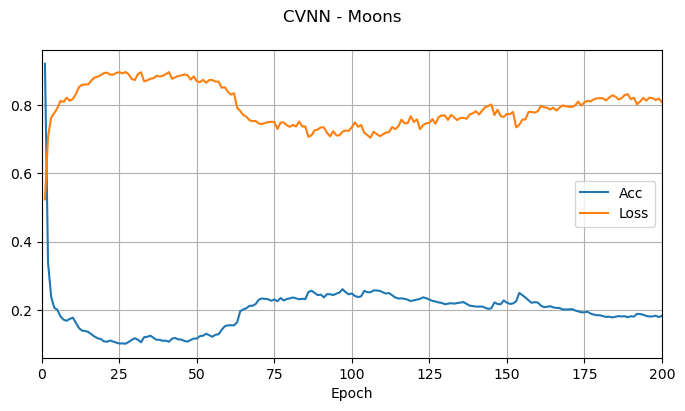

Train Acc.:  0.8973208563004743
Val Acc.:  0.8843886183029992
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1074
           1       0.88      0.85      0.87      1089
           2       0.98      0.95      0.96      1044
           3       0.97      0.96      0.96      1048
           4       0.89      0.86      0.88      1057
           5       0.88      0.88      0.88      1072
           6       0.90      0.83      0.86      1066
           7       1.00      0.99      1.00      1103
           8       1.00      1.00      1.00      1108
           9       0.90      0.90      0.90      1030
          10       0.98      0.95      0.97      1012

   micro avg       0.94      0.92      0.93     11703
   macro avg       0.94      0.92      0.93     11703
weighted avg       0.94      0.92      0.93     11703
 samples avg       0.90      0.92      0.91     11703



In [ ]:
x_train, x_valid, y_train, y_valid = get_splitted_data(X, y, neuronCats)

losses, scores = fit(
    model,
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizer,
    criterion=criterion,
    categories=categories,
    periodicity=periodicity,
)

model.load_state_dict(torch.load(PATH))

plot_loss(
    "CVNN - Autass",
    losses,
    scores,
)

y_pred = model.predict(x_train)
acc = accuracy(y_pred.squeeze(), y_train)
print("Train Acc.: ", acc)

y_pred = model.predict(x_valid)
acc = accuracy(y_pred.squeeze(), y_valid)
print("Val Acc.: ", acc)

print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))

/tmp/ipykernel_188026/1602644682.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


Epoch 9 loss is 0.10144539033235152
Epoch 19 loss is 0.0679025598619397
Epoch 29 loss is 0.05832453244921018
Epoch 39 loss is 0.05330274653409411
Epoch 49 loss is 0.05319324370316005
Epoch 59 loss is 0.044635720249053906
Epoch 69 loss is 0.043026019504023814
Epoch 79 loss is 0.04028874306022859
Epoch 89 loss is 0.04095585907247847
Epoch 99 loss is 0.04000913598848863
Epoch 109 loss is 0.028132917843380293
Epoch 119 loss is 0.05133809219547272
Epoch 129 loss is 0.02603198195086114
Epoch 139 loss is 0.027299120611501294
Epoch 149 loss is 0.02876049258186353
Epoch 159 loss is 0.029775431600440307
Epoch 169 loss is 0.031261582040874064
Epoch 179 loss is 0.031197979172097764
Epoch 189 loss is 0.024516412289404585
Epoch 199 loss is 0.02427502322165331


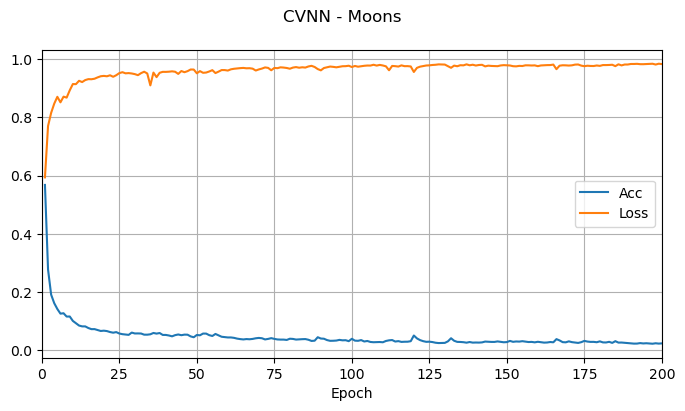

Train Acc.:  0.9843185848270558
Val Acc.:  0.9712869594941036
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1063
           1       0.97      0.96      0.96      1064
           2       1.00      0.99      0.99      1064
           3       1.00      0.99      0.99      1064
           4       0.97      0.97      0.97      1064
           5       0.97      0.96      0.97      1063
           6       0.97      0.95      0.96      1064
           7       1.00      1.00      1.00      1064
           8       1.00      1.00      1.00      1064
           9       0.98      0.96      0.97      1064
          10       0.99      0.98      0.98      1064

   micro avg       0.98      0.98      0.98     11702
   macro avg       0.98      0.98      0.98     11702
weighted avg       0.98      0.98      0.98     11702
 samples avg       0.97      0.98      0.98     11702



/tmp/ipykernel_188026/1602644682.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


: 

: 

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_acc = []
list_loss = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )
    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    plot_loss(
        "CVNN - Autass",
        losses,
        scores,
    )

    list_acc.append(scores)
    list_loss.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    print("Val Acc.: ", acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))

## Plot Model Weights

In [ ]:
# for key in model_dict:
#     print(key)
#     list_weights = model_dict[key]["weights"]
#     list_bias = model_dict[key]["bias"]

#     weights = []
#     biases = []
#     for weight, bias in zip(list_weights, list_bias):
#         # test = list_weights[0][0].flatten() + list_weights[0][1].flatten()
#         weights.append(np.concatenate([weight.flatten()]))
#         biases.append(np.concatenate([bias.flatten()]))

#     weights_real = np.real(weights)
#     weights_imag = np.imag(weights)

#     weights_mag = np.abs(weights)
#     weights_angle = np.angle(weights)

#     bias_real = np.real(biases)
#     bias_imag = np.imag(biases)

#     bias_mag = np.abs(biases)
#     bias_angle = np.angle(biases)

#     plot_weights(str(key)+" weights", "Weights [Re]", "Weigths [Imag]", weights_real, weights_imag)
#     plot_weights(str(key)+" bias", "Bias [Re]", "Bias [Imag]", bias_real, bias_imag)
#     plot_weights(str(key)+" bias", "Bias [Re]", "Bias [Imag]", weights_mag, weights_angle)
#     plot_weights(str(key)+" bias", "Bias [Re]", "Bias [Imag]", bias_mag, bias_angle)